Credits: [Symmetric Skip
Connections Paper](https://arxiv.org/pdf/1606.08921)

In [1]:
import torch.nn as nn
import torch.nn.functional as F

Lets make a random tensor and play around to see how the dimensions work out
Making random tensor because running this locally right now, will work with dataset in colab (mac with 20gb left problems lol)

In [16]:
import torch

x = torch.randn(3, 224, 224)
print("Original x shape, this is how the image is going to be, 3 channels with 224x224 : ", x.shape);
x = x.unsqueeze(0)
print("We have added an extra dimesion to suit required input dimensions: ", x.shape)

# dilation is one by default, keeping that
#( n + 2p - f)/s + 1
c1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1)
x = c1(x) # pass through first consolutional layer
print("enc1: ", x.shape)

c2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
x = c2(x)
print("enc2: ", x.shape)

c3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
x = c3(x)
print("enc3: ", x.shape)

c4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
x = c4(x)
print("enc4: ", x.shape)

c5 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
x = c5(x)
print("enc5: ", x.shape)

c6 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
x = c6(x)
print("enc6: ", x.shape)

Original x shape, this is how the image is going to be, 3 channels with 224x224 :  torch.Size([3, 224, 224])
We have added an extra dimesion to suit required input dimensions:  torch.Size([1, 3, 224, 224])
enc1:  torch.Size([1, 32, 112, 112])
enc2:  torch.Size([1, 32, 56, 56])
enc3:  torch.Size([1, 64, 28, 28])
enc4:  torch.Size([1, 64, 14, 14])
enc5:  torch.Size([1, 128, 7, 7])
enc6:  torch.Size([1, 128, 4, 4])


In [17]:
d1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
x = d1(x)
print("dec1: ", x.shape)

d2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
x = d2(x)
print("dec2: ", x.shape)

d3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
x = d3(x)
print("dec3: ", x.shape)

d4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
x = d4(x)
print("dec4: ", x.shape)

d5 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
x = d5(x)
print("dec5: ", x.shape)

d6 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
x = d6(x)
print("output (reconstructed image): ", x.shape)


dec1:  torch.Size([1, 128, 8, 8])
dec2:  torch.Size([1, 64, 16, 16])
dec3:  torch.Size([1, 64, 32, 32])
dec4:  torch.Size([1, 32, 64, 64])
dec5:  torch.Size([1, 32, 128, 128])
output (reconstructed image):  torch.Size([1, 3, 256, 256])


In [2]:
class SkipAutoencoder(nn.Module):
    def __init__(self):
        super(SkipAutoencoder, self).__init__()

        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.enc5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.enc6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )

        # Decoder (transpose conv)
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.out = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.bn = nn.BatchNorm2d(32)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)     # 128×128
        x2 = self.enc2(x1)    # 64×64
        x3 = self.enc3(x2)    # 32×32  ← skip-1
        x4 = self.enc4(x3)    # 16×16
        x5 = self.enc5(x4)    # 8×8    ← skip-2
        x6 = self.enc6(x5)    # 4×4    ← bottleneck

        # Decoder with matching skips
        y = self.dec1(x6)           # 4 → 8
        y = self.dec2(y + x5)       # 8 → 16
        y = self.dec3(y + x4)       # 16 → 32
        y = self.dec4(y + x3)       # 32 → 64
        y = self.dec5(y + x2)       # 64 → 128
        y = self.out(y + x1)        # 128 → 256
        return y


In [12]:
x = torch.randn(3, 256,256)
x = x.unsqueeze(0)
model = SkipAutoencoder()
y = model(x)
print(y.shape)

torch.Size([1, 3, 256, 256])


In [18]:
!wget -O carpet.tar.xz "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz"

!mkdir -p mvtec/
!tar -xf carpet.tar.xz -C mvtec/
from torchvision import transforms
from torchvision.datasets import ImageFolder


transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

train_images_path = "mvtec/carpet/train"
good_dataset = ImageFolder(train_images_path, transform=transform)
import torch
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

--2025-07-26 14:33:50--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740285760 (706M) [application/x-xz]
Saving to: ‘carpet.tar.xz’

carpet.tar.xz       100%[===================>] 705.99M  19.8MB/s    in 37s     

2025-07-26 14:34:29 (19.0 MB/s) - ‘carpet.tar.xz’ saved [740285760/740285760]



In [19]:
from tqdm import tqdm
import matplotlib.pyplot as plt


In [20]:
import os
from tqdm import trange

def train_skipautoencoder(model, train_loader, test_loader, num_epochs=50, lr=1e-3, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)

    model = model.cuda()
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []



    for epoch in trange(1, num_epochs + 1, desc="Training"):
        model.train()
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.cuda()
            output = model(images)
            loss = criterion(output, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.cuda()
                output = model(images)
                loss = criterion(output, images)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f"Epoch [{epoch:03d}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        if epoch % 10 == 0:
            visualize_reconstruction(model, test_loader, epoch)

        torch.save(model.state_dict(), os.path.join(save_dir, f"autoencoder_epoch_{epoch}.pth"))


    plot_losses(train_losses, val_losses)



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Reconstruction Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def visualize_reconstruction(model, dataloader, epoch):
    import torchvision
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:8].cuda()
    with torch.no_grad():
        outputs = model(images)

    # Denormalized outputs if you normalize input in future
    grid_real = torchvision.utils.make_grid(images.cpu(), nrow=4)
    grid_recon = torchvision.utils.make_grid(outputs.cpu(), nrow=4)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Images (Epoch {epoch})")
    plt.imshow(grid_real.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Reconstructed Images (Epoch {epoch})")
    plt.imshow(grid_recon.permute(1, 2, 0))
    plt.axis("off")

    plt.show()


In [21]:
model = SkipAutoencoder()

[001/50] Train Loss: 0.024578 | Val Loss: 0.018691
[002/50] Train Loss: 0.016288 | Val Loss: 0.014751
[003/50] Train Loss: 0.013642 | Val Loss: 0.013198
[004/50] Train Loss: 0.011893 | Val Loss: 0.010956
[005/50] Train Loss: 0.009443 | Val Loss: 0.008230
[006/50] Train Loss: 0.006960 | Val Loss: 0.005855
[007/50] Train Loss: 0.004970 | Val Loss: 0.004343
[008/50] Train Loss: 0.003731 | Val Loss: 0.003410
[009/50] Train Loss: 0.002993 | Val Loss: 0.002822
[010/50] Train Loss: 0.002606 | Val Loss: 0.002482


[011/50] Train Loss: 0.002298 | Val Loss: 0.002230
[012/50] Train Loss: 0.002077 | Val Loss: 0.002068
[013/50] Train Loss: 0.001935 | Val Loss: 0.001866
[014/50] Train Loss: 0.001779 | Val Loss: 0.001805
[015/50] Train Loss: 0.001647 | Val Loss: 0.001679
[016/50] Train Loss: 0.001528 | Val Loss: 0.001510
[017/50] Train Loss: 0.001413 | Val Loss: 0.001440
[018/50] Train Loss: 0.001324 | Val Loss: 0.001362
[019/50] Train Loss: 0.001241 | Val Loss: 0.001245
[020/50] Train Loss: 0.001172 | Val Loss: 0.001176


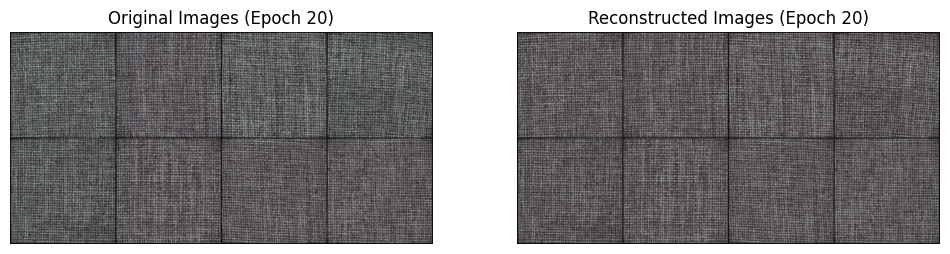

[021/50] Train Loss: 0.001114 | Val Loss: 0.001127
[022/50] Train Loss: 0.001041 | Val Loss: 0.001042
[023/50] Train Loss: 0.001001 | Val Loss: 0.001087
[024/50] Train Loss: 0.000956 | Val Loss: 0.000947
[025/50] Train Loss: 0.000878 | Val Loss: 0.000882
[026/50] Train Loss: 0.000834 | Val Loss: 0.000822
[027/50] Train Loss: 0.000797 | Val Loss: 0.000790
[028/50] Train Loss: 0.000752 | Val Loss: 0.000762
[029/50] Train Loss: 0.000721 | Val Loss: 0.000751
[030/50] Train Loss: 0.000702 | Val Loss: 0.000697


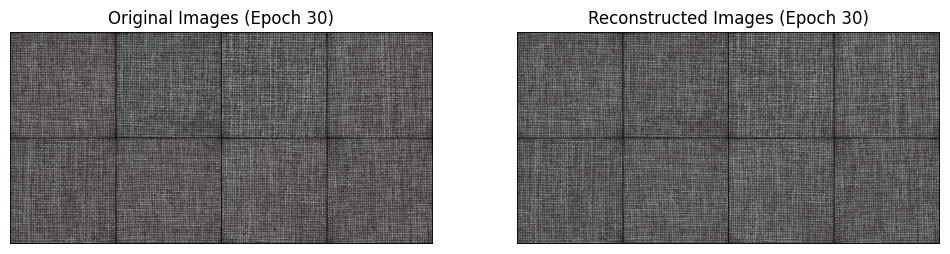

[031/50] Train Loss: 0.000667 | Val Loss: 0.000679
[032/50] Train Loss: 0.000642 | Val Loss: 0.000661
[033/50] Train Loss: 0.000623 | Val Loss: 0.000627
[034/50] Train Loss: 0.000610 | Val Loss: 0.000646
[035/50] Train Loss: 0.000590 | Val Loss: 0.000592
[036/50] Train Loss: 0.000559 | Val Loss: 0.000579
[037/50] Train Loss: 0.000544 | Val Loss: 0.000555
[038/50] Train Loss: 0.000528 | Val Loss: 0.000538
[039/50] Train Loss: 0.000511 | Val Loss: 0.000520
[040/50] Train Loss: 0.000501 | Val Loss: 0.000510


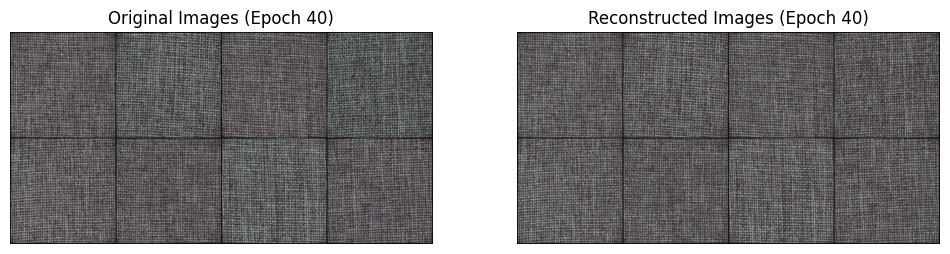

[041/50] Train Loss: 0.000489 | Val Loss: 0.000494
[042/50] Train Loss: 0.000490 | Val Loss: 0.000490
[043/50] Train Loss: 0.000485 | Val Loss: 0.000508
[044/50] Train Loss: 0.000463 | Val Loss: 0.000464
[045/50] Train Loss: 0.000447 | Val Loss: 0.000475
[046/50] Train Loss: 0.000436 | Val Loss: 0.000447
[047/50] Train Loss: 0.000421 | Val Loss: 0.000430
[048/50] Train Loss: 0.000412 | Val Loss: 0.000424
[049/50] Train Loss: 0.000408 | Val Loss: 0.000421
[050/50] Train Loss: 0.000410 | Val Loss: 0.000414


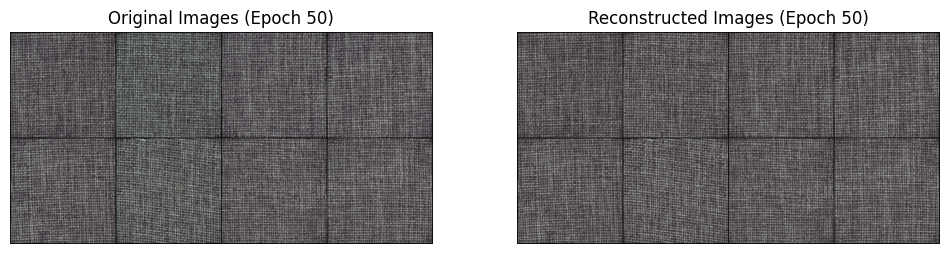

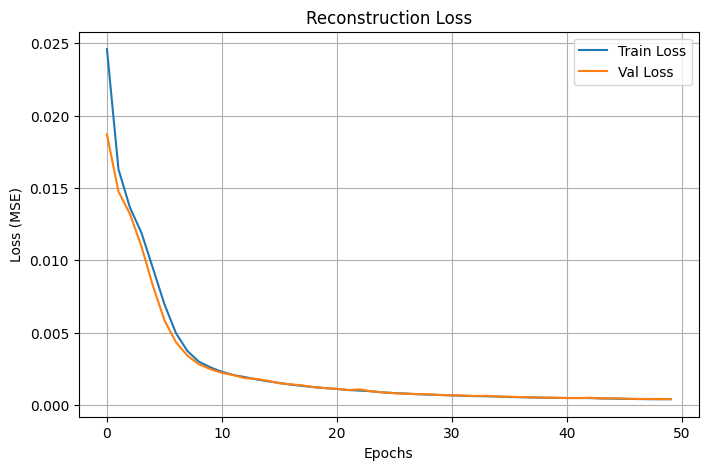

In [22]:
train_skipautoencoder(model, train_loader, test_loader)

Yes I am reusing the snippets, will put it in utils or something

In [25]:
from PIL import Image
import numpy as np

def compare_show_loss(img_path: str, model: torch.nn.Module) -> None:

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).cuda()

    model.eval()
    with torch.no_grad():
        output_tensor = model(input_tensor)

    original = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    reconstructed = output_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

    loss_map = np.abs(original - reconstructed)  # still [256, 256, 3]
    loss_map_gray = np.mean(loss_map, axis=2)

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(loss_map_gray, cmap='jet', vmax=loss_map_gray.max()) # normalize the values
    plt.title("Reconstruction Loss Map")
    plt.axis("off")
    # plt.colorbar(shrink=0.7, pad=0.01)

    plt.tight_layout()
    plt.show()



In [23]:
model = SkipAutoencoder().cuda()
# i renamed the autoencoder_epoch_50.pth to skipautoencoder_epoch_50.pth
model.load_state_dict(torch.load("checkpoints/skipautoencoder_epoch_50.pth"))
model.eval()


SkipAutoencoder(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc6): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (dec1): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    

In [24]:
samples_show = ["mvtec/carpet/train/good/005.png", "mvtec/carpet/test/good/005.png", "mvtec/carpet/test/cut/005.png", "mvtec/carpet/test/hole/005.png", "mvtec/carpet/test/metal_contamination/005.png",]

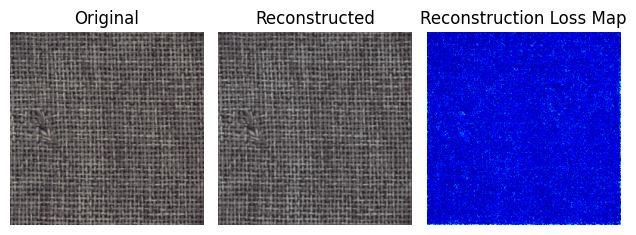

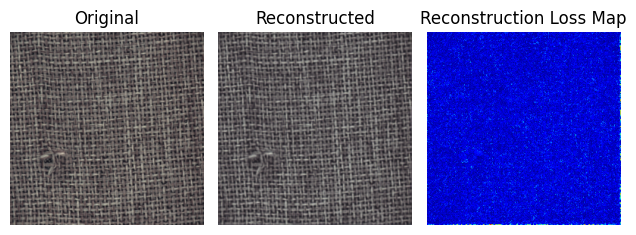

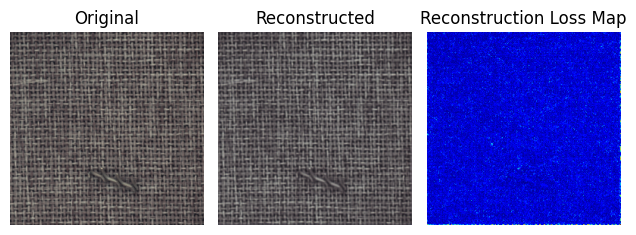

In [26]:
for img in samples_show:
  compare_show_loss(img,model)

Model is not doing a good job!

In [27]:
compare_show_loss("mvtec/carpet/test/color/000.png",model)


In [28]:
compare_show_loss("mvtec/carpet/test/thread/015.png", model)

In [29]:
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix


def evaluate_model_metrics(model: torch.nn.Module, train_loader, test_dir: str, transform) -> dict:
    model.eval()
    model = model.cuda()

    # calcualte threshold from training images
    recon_errors = []
    with torch.no_grad():
        for data, _ in train_loader:
            data = data.cuda()
            recon = model(data)
            mse = ((data - recon) ** 2).mean(dim=(1))[:, :-10, :-10].mean(dim=(1, 2))  # prevent boundary artifacts
            recon_errors.append(mse)

    recon_errors = torch.cat(recon_errors).cpu().numpy()
    threshold = np.mean(recon_errors) + 3 * np.std(recon_errors)  # 3σ threshold

    # evaluate on test set
    y_true, y_score, y_pred = [], [], []

    test_path = Path(test_dir)
    with torch.no_grad():
        for path in test_path.glob("*/*.png"):
            label = 0 if path.parts[-2] == 'good' else 1
            image = transform(Image.open(path).convert("RGB")).unsqueeze(0).cuda()
            recon = model(image)
            mse = ((image - recon) ** 2).mean(dim=(1))[:, :-10, :-10].mean().item()

            y_true.append(label)
            y_score.append(mse)
            y_pred.append(1 if mse >= threshold else 0)

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    y_pred = np.array(y_pred)

    # calculate metrics
    auc = roc_auc_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return {
        "AUC-ROC": auc,
        "F1-score": f1,
        "Precision": precision,
        "Recall": recall,
        "Threshold": threshold,
        "ConfusionMatrix": cm
    }


In [30]:
from torchvision import transforms

metrics = evaluate_model_metrics(model, train_loader, "mvtec/carpet/test", transform)

for k, v in metrics.items():
    if k != "ConfusionMatrix":
        print(f"{k}: {v:.4f}")
print("Confusion Matrix:\n", metrics["ConfusionMatrix"])


AUC-ROC: 0.4109
F1-score: 0.0000
Precision: 0.0000
Recall: 0.0000
Threshold: 0.0005
Confusion Matrix:
 [[28  0]
 [89  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NOTE: The model currently reconstructs both good and defective images too well,
leading to low reconstruction error across the board. As a result, the anomaly
threshold is too high and fails to detect defects. Consider visualizing the
reconstruction error distribution, adjusting the threshold manually, or switching
to a bottleneck-heavy or denoising autoencoder for better anomaly detection.


# Lets try SSIM

In [ ]:
!pip install pytorch-msssim

 **SSIM (Structural Similarity Index Measure)** is a widely used metric for measuring the **perceived quality of an image**, especially in tasks like:

* Autoencoders
* Image denoising
* Image generation (GANs, etc.)
* Image compression

Unlike simple metrics like **MSE**, SSIM focuses on **structural information** — i.e., patterns and textures that are important to human vision.

---

## What Is SSIM?

SSIM compares two images based on:

### 1. **Luminance (brightness)**

Mean of each patch

$$
l(x, y) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}
$$

### 2. **Contrast (standard deviation)**

$$
c(x, y) = \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}
$$

### 3. **Structure (correlation)**

$$
s(x, y) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3}
$$

Then:

$$
\text{SSIM}(x, y) = [l(x, y)]^\alpha \cdot [c(x, y)]^\beta \cdot [s(x, y)]^\gamma
$$

Usually, we take:

$$
\alpha = \beta = \gamma = 1 \Rightarrow \text{SSIM}(x, y) = l(x, y) \cdot c(x, y) \cdot s(x, y)
$$

Values range from **-1 to 1**, where:

* 1 = identical
* <1 = less similar

---

## SSIM Hyperparameters

* **Window size**: patch size (e.g., 11×11 Gaussian)
* **Sigma**: controls the spread of Gaussian filter
* **C1 and C2**: stability constants:

  $$
  C_1 = (K_1 L)^2, \quad C_2 = (K_2 L)^2
  $$

  Where `L` is dynamic range (e.g., 255 for uint8, or 1.0 for float), and `K1`, `K2` are usually small (like 0.01 and 0.03)

---

## Notes:

* Your images must be **normalized between \[0, 1]** (use `.clamp(0, 1)` if unsure).
* SSIM is **differentiable** → can be used as a **loss function**:

  ```python
  loss = 1 - ssim(x, y, data_range=1.0)
  ```

---

In [34]:
from pytorch_msssim import SSIM

ssim_loss_fn = SSIM(data_range=1.0, size_average=True).cuda()

In [35]:
import os
from tqdm import trange
import torch
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
import torchvision

def train_skipautoencoder_ssim(model, train_loader, test_loader, num_epochs=50, lr=1e-3, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)

    model = model.cuda()
    criterion = SSIM(data_range=1.0, size_average=True).cuda()  # SSIM Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in trange(1, num_epochs + 1, desc="Training"):
        model.train()
        running_loss = 0.0

        for images, _ in train_loader:
            images = images.cuda()

            output = model(images)
            loss = 1 - criterion(output, images)  # SSIM maximized → minimize 1 - SSIM

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.cuda()
                output = model(images)
                loss = 1 - criterion(output, images)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f"Epoch [{epoch:03d}/{num_epochs}] | Train SSIM Loss: {avg_train_loss:.6f} | Val SSIM Loss: {avg_val_loss:.6f}")

        if epoch % 10 == 0:
            visualize_reconstruction(model, test_loader, epoch)

        torch.save(model.state_dict(), os.path.join(save_dir, f"autoencoder_epoch_{epoch}.pth"))

    plot_losses(train_losses, val_losses)


Training:   2%|▏         | 1/50 [00:14<12:04, 14.78s/it]

Epoch [001/50] | Train SSIM Loss: 0.863396 | Val SSIM Loss: 0.770817


Training:   4%|▍         | 2/50 [00:29<11:38, 14.56s/it]

Epoch [002/50] | Train SSIM Loss: 0.578898 | Val SSIM Loss: 0.369605


Training:   6%|▌         | 3/50 [00:43<11:15, 14.37s/it]

Epoch [003/50] | Train SSIM Loss: 0.291111 | Val SSIM Loss: 0.220927


Training:   8%|▊         | 4/50 [00:57<10:58, 14.31s/it]

Epoch [004/50] | Train SSIM Loss: 0.184960 | Val SSIM Loss: 0.150064


Training:  10%|█         | 5/50 [01:11<10:42, 14.28s/it]

Epoch [005/50] | Train SSIM Loss: 0.129986 | Val SSIM Loss: 0.109927


Training:  12%|█▏        | 6/50 [01:25<10:22, 14.15s/it]

Epoch [006/50] | Train SSIM Loss: 0.096967 | Val SSIM Loss: 0.083629


Training:  14%|█▍        | 7/50 [01:39<10:08, 14.15s/it]

Epoch [007/50] | Train SSIM Loss: 0.075571 | Val SSIM Loss: 0.066776


Training:  16%|█▌        | 8/50 [01:55<10:13, 14.60s/it]

Epoch [008/50] | Train SSIM Loss: 0.061080 | Val SSIM Loss: 0.054705


Training:  18%|█▊        | 9/50 [02:10<10:06, 14.79s/it]

Epoch [009/50] | Train SSIM Loss: 0.050336 | Val SSIM Loss: 0.045670


Training:  18%|█▊        | 9/50 [02:24<10:06, 14.79s/it]

Epoch [010/50] | Train SSIM Loss: 0.042633 | Val SSIM Loss: 0.039359


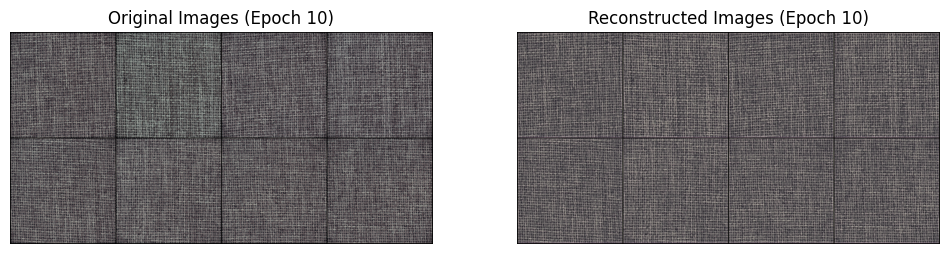

Training:  22%|██▏       | 11/50 [02:39<09:26, 14.54s/it]

Epoch [011/50] | Train SSIM Loss: 0.037316 | Val SSIM Loss: 0.034965


Training:  24%|██▍       | 12/50 [02:53<09:04, 14.33s/it]

Epoch [012/50] | Train SSIM Loss: 0.033398 | Val SSIM Loss: 0.031721


Training:  26%|██▌       | 13/50 [03:07<08:53, 14.42s/it]

Epoch [013/50] | Train SSIM Loss: 0.030487 | Val SSIM Loss: 0.029190


Training:  28%|██▊       | 14/50 [03:24<09:04, 15.12s/it]

Epoch [014/50] | Train SSIM Loss: 0.028021 | Val SSIM Loss: 0.026826


Training:  30%|███       | 15/50 [03:38<08:37, 14.77s/it]

Epoch [015/50] | Train SSIM Loss: 0.025760 | Val SSIM Loss: 0.024542


Training:  32%|███▏      | 16/50 [03:52<08:13, 14.50s/it]

Epoch [016/50] | Train SSIM Loss: 0.023624 | Val SSIM Loss: 0.023029


Training:  34%|███▍      | 17/50 [04:06<07:51, 14.29s/it]

Epoch [017/50] | Train SSIM Loss: 0.021931 | Val SSIM Loss: 0.020959


Training:  36%|███▌      | 18/50 [04:20<07:33, 14.18s/it]

Epoch [018/50] | Train SSIM Loss: 0.020149 | Val SSIM Loss: 0.019415


Training:  38%|███▊      | 19/50 [04:34<07:17, 14.12s/it]

Epoch [019/50] | Train SSIM Loss: 0.018745 | Val SSIM Loss: 0.018174


Training:  38%|███▊      | 19/50 [04:48<07:17, 14.12s/it]

Epoch [020/50] | Train SSIM Loss: 0.017533 | Val SSIM Loss: 0.016992


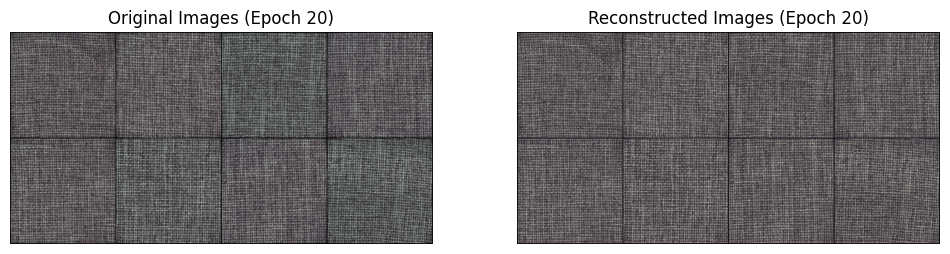

Training:  42%|████▏     | 21/50 [05:03<06:58, 14.42s/it]

Epoch [021/50] | Train SSIM Loss: 0.016470 | Val SSIM Loss: 0.016052


Training:  44%|████▍     | 22/50 [05:17<06:40, 14.29s/it]

Epoch [022/50] | Train SSIM Loss: 0.015498 | Val SSIM Loss: 0.015138


Training:  46%|████▌     | 23/50 [05:31<06:22, 14.18s/it]

Epoch [023/50] | Train SSIM Loss: 0.014638 | Val SSIM Loss: 0.014463


Training:  48%|████▊     | 24/50 [05:45<06:06, 14.11s/it]

Epoch [024/50] | Train SSIM Loss: 0.013936 | Val SSIM Loss: 0.013787


Training:  50%|█████     | 25/50 [05:59<05:51, 14.06s/it]

Epoch [025/50] | Train SSIM Loss: 0.013308 | Val SSIM Loss: 0.012922


Training:  52%|█████▏    | 26/50 [06:13<05:37, 14.07s/it]

Epoch [026/50] | Train SSIM Loss: 0.012588 | Val SSIM Loss: 0.012407


Training:  54%|█████▍    | 27/50 [06:28<05:26, 14.21s/it]

Epoch [027/50] | Train SSIM Loss: 0.012049 | Val SSIM Loss: 0.011929


Training:  56%|█████▌    | 28/50 [06:42<05:10, 14.11s/it]

Epoch [028/50] | Train SSIM Loss: 0.011539 | Val SSIM Loss: 0.011413


Training:  58%|█████▊    | 29/50 [06:56<04:55, 14.06s/it]

Epoch [029/50] | Train SSIM Loss: 0.011073 | Val SSIM Loss: 0.011047


Training:  58%|█████▊    | 29/50 [07:10<04:55, 14.06s/it]

Epoch [030/50] | Train SSIM Loss: 0.010706 | Val SSIM Loss: 0.010582


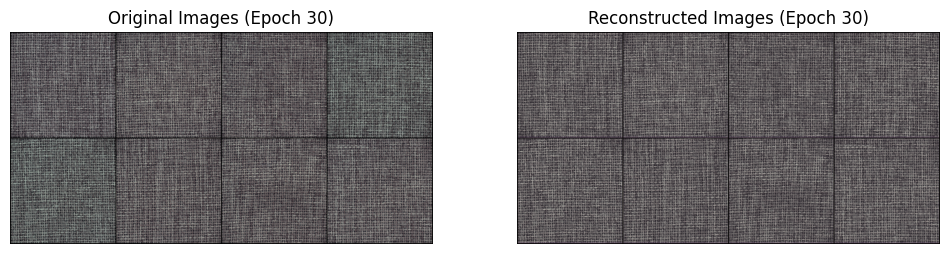

Training:  62%|██████▏   | 31/50 [07:24<04:29, 14.20s/it]

Epoch [031/50] | Train SSIM Loss: 0.010306 | Val SSIM Loss: 0.010209


Training:  64%|██████▍   | 32/50 [07:38<04:13, 14.09s/it]

Epoch [032/50] | Train SSIM Loss: 0.009984 | Val SSIM Loss: 0.010022


Training:  66%|██████▌   | 33/50 [07:53<04:01, 14.19s/it]

Epoch [033/50] | Train SSIM Loss: 0.009701 | Val SSIM Loss: 0.009627


Training:  68%|██████▊   | 34/50 [08:07<03:46, 14.13s/it]

Epoch [034/50] | Train SSIM Loss: 0.009433 | Val SSIM Loss: 0.009356


Training:  70%|███████   | 35/50 [08:21<03:31, 14.07s/it]

Epoch [035/50] | Train SSIM Loss: 0.009132 | Val SSIM Loss: 0.009105


Training:  72%|███████▏  | 36/50 [08:35<03:16, 14.03s/it]

Epoch [036/50] | Train SSIM Loss: 0.008823 | Val SSIM Loss: 0.008732


Training:  74%|███████▍  | 37/50 [08:49<03:01, 14.00s/it]

Epoch [037/50] | Train SSIM Loss: 0.008547 | Val SSIM Loss: 0.008632


Training:  76%|███████▌  | 38/50 [09:02<02:47, 13.98s/it]

Epoch [038/50] | Train SSIM Loss: 0.008389 | Val SSIM Loss: 0.008359


Training:  78%|███████▊  | 39/50 [09:16<02:33, 13.98s/it]

Epoch [039/50] | Train SSIM Loss: 0.008187 | Val SSIM Loss: 0.008173


Training:  78%|███████▊  | 39/50 [09:31<02:33, 13.98s/it]

Epoch [040/50] | Train SSIM Loss: 0.007987 | Val SSIM Loss: 0.007965


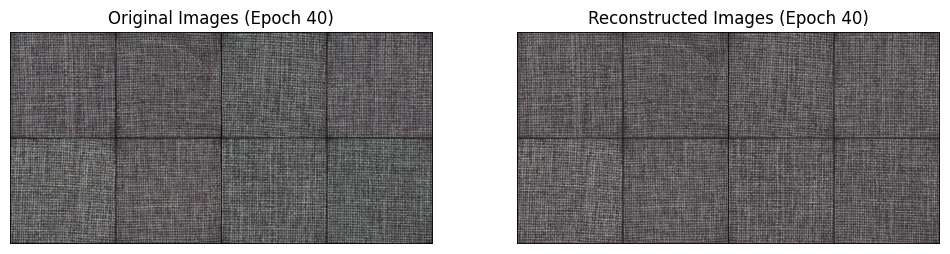

Training:  82%|████████▏ | 41/50 [09:46<02:08, 14.31s/it]

Epoch [041/50] | Train SSIM Loss: 0.007733 | Val SSIM Loss: 0.007718


Training:  84%|████████▍ | 42/50 [10:00<01:53, 14.18s/it]

Epoch [042/50] | Train SSIM Loss: 0.007528 | Val SSIM Loss: 0.007602


Training:  86%|████████▌ | 43/50 [10:14<01:38, 14.09s/it]

Epoch [043/50] | Train SSIM Loss: 0.007368 | Val SSIM Loss: 0.007532


Training:  88%|████████▊ | 44/50 [10:28<01:23, 14.00s/it]

Epoch [044/50] | Train SSIM Loss: 0.007245 | Val SSIM Loss: 0.007248


Training:  90%|█████████ | 45/50 [10:41<01:09, 13.92s/it]

Epoch [045/50] | Train SSIM Loss: 0.007019 | Val SSIM Loss: 0.007282


Training:  92%|█████████▏| 46/50 [10:56<00:56, 14.06s/it]

Epoch [046/50] | Train SSIM Loss: 0.006954 | Val SSIM Loss: 0.006873


Training:  94%|█████████▍| 47/50 [11:09<00:41, 13.95s/it]

Epoch [047/50] | Train SSIM Loss: 0.006728 | Val SSIM Loss: 0.006805


Training:  96%|█████████▌| 48/50 [11:23<00:27, 13.90s/it]

Epoch [048/50] | Train SSIM Loss: 0.006635 | Val SSIM Loss: 0.006624


Training:  98%|█████████▊| 49/50 [11:37<00:13, 13.84s/it]

Epoch [049/50] | Train SSIM Loss: 0.006468 | Val SSIM Loss: 0.006528


Training:  98%|█████████▊| 49/50 [11:51<00:13, 13.84s/it]

Epoch [050/50] | Train SSIM Loss: 0.006343 | Val SSIM Loss: 0.006363


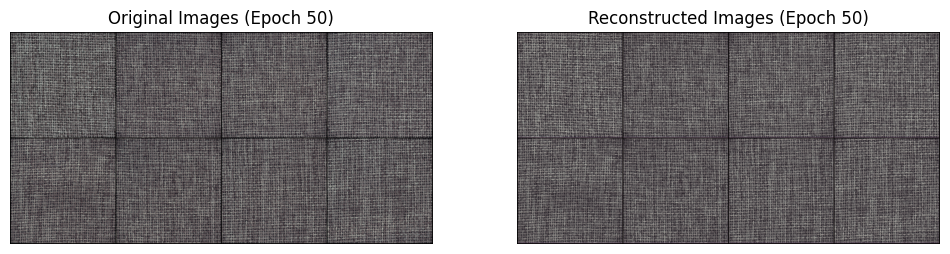

Training: 100%|██████████| 50/50 [11:52<00:00, 14.25s/it]


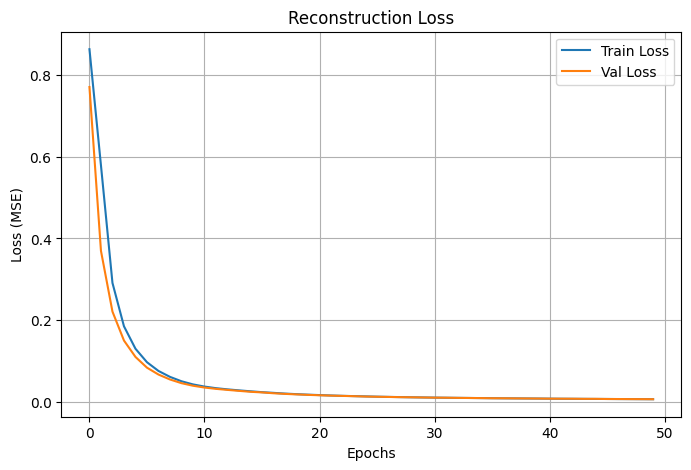

In [36]:
model_ssim = SkipAutoencoder()
train_skipautoencoder_ssim(model_ssim, train_loader, test_loader)

In [37]:
from torchvision import transforms

metrics = evaluate_model_metrics(model_ssim, train_loader, "mvtec/carpet/test", transform)

for k, v in metrics.items():
    if k != "ConfusionMatrix":
        print(f"{k}: {v:.4f}")
print("Confusion Matrix:\n", metrics["ConfusionMatrix"])


AUC-ROC: 0.5995
F1-score: 0.0000
Precision: 0.0000
Recall: 0.0000
Threshold: 0.0003
Confusion Matrix:
 [[28  0]
 [89  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Anomaly Detection Evaluation on MVTec Carpet, comparing the pixel space autoencoder approaches tried

### Metric Summary

| Model                          | AUC-ROC | F1-score | Precision | Recall | Threshold | Notes |
|-------------------------------|---------|----------|-----------|--------|-----------|-------|
| **Plain Autoencoder (MSE)** (done in train_autoencoder.ipynb previously)   | ~0.44   | low      | low       | low    | -         | Baseline model, trained with MSE loss |
| **Skip Connection Autoencoder (MSE)** | ~0.41   | low      | low       | low    | -         | Structural improvement but no metric gain |
| **Skip AE with SSIM loss**    | **0.5995** | **0.0000**  | **0.0000**   | **0.0000**| 0.0003    | Trained with SSIM; higher AUC-ROC but threshold failed to capture anomalies |

---

### Observations

- **AUC-ROC improved** (0.44 → 0.60) using SSIM as the anomaly score, this means the model is ranking defective samples better, even if thresholding failed.
- **F1, Precision, Recall all 0.0**: this usually indicates **no positive predictions were made** — all samples were predicted as "good".
  - This happens when the **threshold is too high** or the **distribution of SSIM error is too tight** (as seen: threshold = 0.0003).
